In [3]:
import pandas as pd
import numpy as np

#base_path = "C:/Users/Rafael/Documents/data/DMC/data/"
base_path = "C:/Users/rcrescenzi/Documents/Personal/data/DMC/data/"
raw_path = base_path + "raw/"
encoded_path = base_path + "raw_wvalid/"
reco_path = base_path + "meta_reco/"
mway_path = base_path + "meta_mway/"
stage_1_path = base_path + "probs_stage_1/"
stage_2_path = base_path + "probs_stage_2/"

In [4]:
train = pd.read_csv(raw_path + "train.txt", sep=";", na_values="NA",
                    keep_default_na=False, parse_dates=[1])
test = pd.read_csv(raw_path + "test.txt", sep=";", na_values="NA",
                    keep_default_na=False, parse_dates=[1])

data = pd.concat([train, test])
data.index = range(data.shape[0])
del train, test

In [5]:
data.head(10)

,articleID,colorCode,customerID,deviceID,orderDate,orderID,paymentMethod,price,productGroup,quantity,returnQuantity,rrp,sizeCode,voucherAmount,voucherID
0,i1000382,1972,c1010575,2,2014-01-01,a1000001,BPRG,10.00,3.0,1,0.0,29.99,44,0.0,0
1,i1000550,3854,c1010575,2,2014-01-01,a1000001,BPRG,20.00,3.0,1,0.0,39.99,44,0.0,0
2,i1001991,2974,c1045905,4,2014-01-01,a1000002,BPRG,35.00,8.0,1,0.0,49.99,38,0.0,0
3,i1001999,1992,c1045905,4,2014-01-01,a1000002,BPRG,49.99,8.0,1,1.0,49.99,38,0.0,0
4,i1001942,1968,c1089295,2,2014-01-01,a1000003,PAYPALVC,10.00,8.0,1,0.0,35.99,42,0.0,0
5,i1001942,1972,c1089295,2,2014-01-01,a1000003,PAYPALVC,10.00,8.0,1,0.0,35.99,42,0.0,0
6,i1001974,1001,c1089295,2,2014-01-01,a1000003,PAYPALVC,25.00,8.0,1,0.0,39.99,42,0.0,0
7,i1001976,3976,c1089295,2,2014-01-01,a1000003,PAYPALVC,15.00,8.0,1,0.0,39.99,44,0.0,0
8,i1002392,2493,c1089295,2,2014-01-01,a1000003,PAYPALVC,0.00,13.0,0,0.0,59.99,42,0.0,0
9,i1002457,1001,c1050116,3,2014-01-01,a1000004,BPRG,89.99,14.0,1,1.0,89.99,42,0.0,0


<img src="variables.png">
<img src="files/target.png">
<img src="files/fi.jpg">

### Esquema de Validación Cruzada

<img src="files/cv_est.png">

In [ ]:
if False:
    codify_cols = ["articleID", "colorCode", "sizeCode",
                   "customerID", "paymentMethod", "voucherID",
                   "deviceID", "productGroup"]

    temp = data.groupby("orderID").price.sum()
    temp.name = "order_value"
    data["order_value"] = data.join(temp, on="orderID")["order_value"]

    temp = data.groupby("orderID").quantity.sum()
    temp.name = "order_quantity"
    data["order_quantity"] = data.join(temp, on="orderID")["order_quantity"]

    data["unit_price"] = (data.price / data.quantity).fillna(0)
    data["rrp"].fillna(data.unit_price, inplace=True)
    data["productGroup"].fillna(0, inplace=True)
    data["voucherID"].fillna("0", inplace=True)
    data["rrp_price_ratio"] = (data.unit_price / data.rrp).fillna(0)
    data["order_unit_price_ratio"] = (data.unit_price / data.order_value).fillna(0)
    data["order_price_ratio"] = (data.price / data.order_value).fillna(0)
    data["order_quant_ratio"] = (data.quantity / data.order_quantity).fillna(0)

    data["order_discount_percent"] = (data.voucherAmount / data.order_value).fillna(0)
    data["paid_price"] = data.price * (1 - data.order_discount_percent)

    temp = data.groupby("articleID").unit_price.mean()
    temp.name = "art_mean_price"
    data["mean_price_ratio"] = (data.unit_price / data.join(temp, on="articleID")["art_mean_price"]).fillna(0)

    data["month"]  = data.orderDate.dt.month
    data["week"] = data.orderDate.dt.week
    data["day"] = data.orderDate.dt.day
    data["quincena"] = (data.month - 1) * 2 + (data.day > 15)
    data["weekday"] = data.orderDate.dt.weekday

    temp = data.groupby(["orderID", "articleID"])
    temp_data = temp.quantity.sum()
    temp_data.name = "item_quantity"
    data = data.join(temp_data, on=["orderID", "articleID"])
    data["item_quantity_ratio"] = (data.quantity / data.item_quantity).fillna(0)

    temp = data.groupby(["orderID", "articleID", "colorCode"])
    temp_data = temp.quantity.sum()
    temp_data.name = "item_quantity_color"
    data = data.join(temp_data, on=["orderID", "articleID", "colorCode"])

    temp = data.groupby(["orderID", "articleID", "sizeCode"])
    temp_data = temp.quantity.sum()
    temp_data.name = "item_quantity_size"
    data = data.join(temp_data, on=["orderID", "articleID", "sizeCode"])

    data["item_dif_size"] = data.item_quantity != data.item_quantity_size
    data["item_dif_color"] = data.item_quantity != data.item_quantity_color

    for c in data.columns:
        if data[c].dtype not in ["object", "datetime64[ns]"]:
            data[c] = data[c].astype(np.float32)

    folds = [["2014-12-31", ("2015-1-01", "2015-3-31")],
             ["2015-3-31", ("2015-4-01", "2015-6-30")],
             ["2015-6-30", ("2015-7-01", "2015-9-30")],
             ["2015-9-30", ("2015-10-01", "2015-12-31")]]


    for i, fold in enumerate(folds):
        for c in codify_cols:
            ct = encode(data[data.orderDate <= fold[0]][[c, "returnQuantity"]], c, "returnQuantity")
            data[c + "_encoded"] =  data[c].apply(lambda x: ct[x]).astype(np.float32)
        tdir = target_path + "fold_" + str(i + 1) + "/"
        if not os.path.exists(tdir):
            os.mkdir(tdir)
        data[data.orderDate <= fold[0]].to_pickle(tdir + "train.p")
        data[(data.orderDate >= fold[1][0]) & (data.orderDate <= fold[1][1])].to_pickle(tdir + "test.p")

In [5]:
print(data.apply(lambda x: x.unique().shape[0]))
del data

articleID           4241
colorCode            642
customerID        342038
deviceID               5
orderDate            730
orderID           849185
paymentMethod         10
price                273
productGroup          32
quantity              11
returnQuantity         7
rrp                   46
sizeCode              29
voucherAmount       1800
voucherID            844
dtype: int64

# codificación de variables categóricas

## One hot encoding, aka variables dummies

Es el método más usado, pero tiende a tener serios problemas cuando las variables tienen una alta cardinalidad (por ejemplo: color_code -> 642)

## Codificación "bayesiana"

Implica "filtrar" algo de infomación del target, por eso hay que hacerlo con cuidado. Es buena particularmente para los árboles, porque permite ordenar los casos de una manera consistente al target. 

Para variables en las cuales cada categoría tiene una cantidad de casos relativamente "alta", es simplemente:

&nbsp;&nbsp;&nbsp;&nbsp; $\hat{p} = \dfrac{N_{iy}}{N_{i}}$ <br />

**Donde:**

&nbsp;&nbsp;&nbsp;&nbsp; $N_{i}: \text{la cantidad de casos para la categoría i}$ <br />
&nbsp;&nbsp;&nbsp;&nbsp; $N_{iy}: \text{la cantidad de casos de la categoría i que tienen un target positivo}$<br />
    
Esto es análogo al parámetro p de una distribución dicotómica, que se está infiriendo de una muestra. Cuando tenemos pocos casos de una determinada categoría, es un simil a tener una muestra muy pequeña, por tanto, la estimación puede ser muy mala; o pero, buena para el set de entrenamiento y mala en el set de prueba; lo cual llevaría al árbol a hacer cortes teóricamente muy buenos, pero que generalizar terriblemente mal. 

Para solucionar este problema, se puede recurrir a un estimador bayesiano de la variable p (para Bayes, p no es un parámetro, sino una variable aleatoria).

Una forma posible de ese estimador es:

&nbsp;&nbsp;&nbsp;&nbsp; $Ponderador(N_{i}, \sigma_{i}) = \frac{N_{i} * \sigma^{2}}{(\sigma_{i}^{2} + N_{i} * \sigma^{2})}$ <br />

&nbsp;&nbsp;&nbsp;&nbsp; $\hat{p} = Ponderador(N_{i}, \sigma_{i}) * \dfrac{N_{iy}}{N_{i}} - (1 - Ponderador(N_{i}, \sigma_{i})) * \dfrac{N_{y}}{N}$

**Donde:**

&nbsp;&nbsp;&nbsp;&nbsp; $\sigma^{2}: \text{es la varianza total de la variable target}$<br />
&nbsp;&nbsp;&nbsp;&nbsp; $\sigma_{i}^{2}: \text{es la varianza de la variable target dentro de la categoria i}$<br />
&nbsp;&nbsp;&nbsp;&nbsp; $N_{y}: \text{es la cantidad total de targets positivos}$<br />
&nbsp;&nbsp;&nbsp;&nbsp; $N: \text{es la cantidad total de elementos en el dataset}$<br />

<img src="files/ponderadores.png">

In [30]:
train = pd.read_pickle(encoded_path + "fold_3/train.p")
test = pd.read_pickle(encoded_path + "fold_3/test.p")
encoded_cols = train.filter(regex="_encoded$").columns

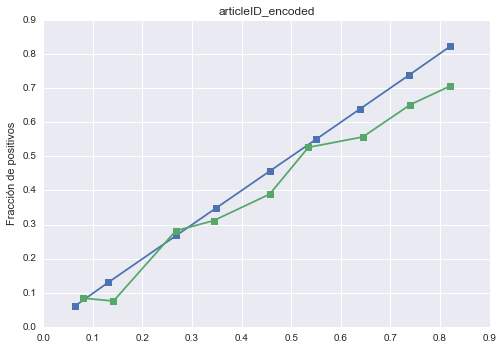

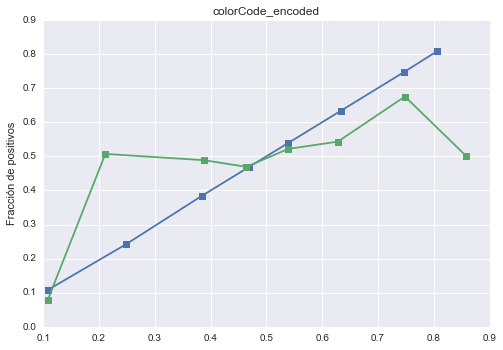

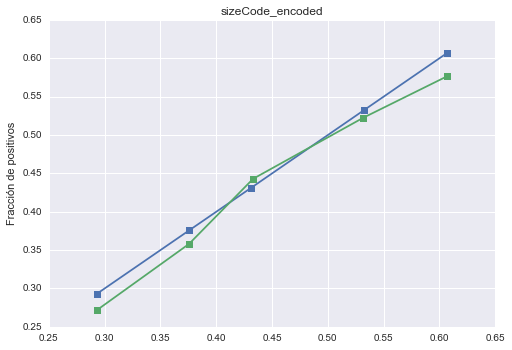

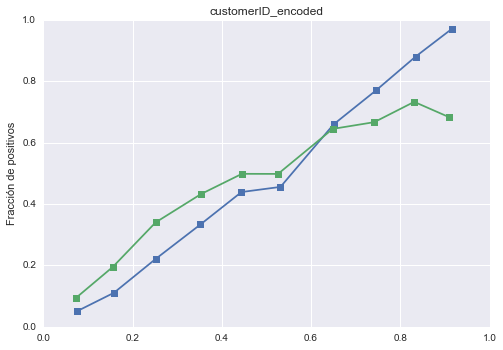

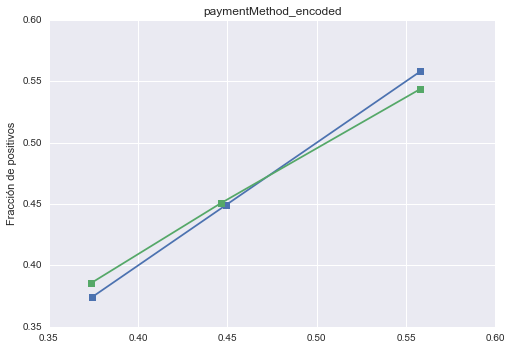

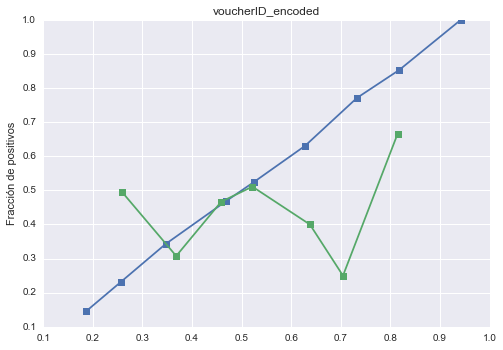

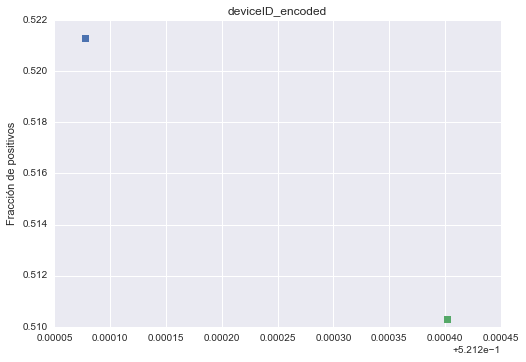

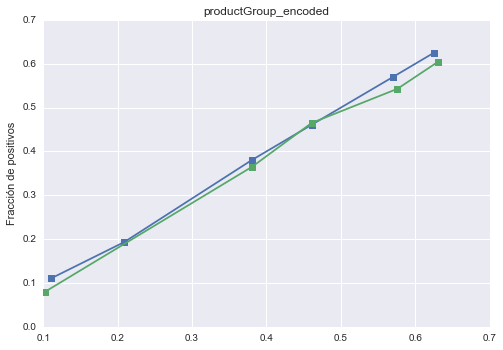

In [27]:
%matplotlib inline
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

for c in encoded_cols:
    ax = plt.figure().add_subplot(111)
    fraction_of_positives, mean_predicted_value = calibration_curve(train.returnQuantity > 0, train[c], n_bins=10)
    ax.plot(mean_predicted_value, fraction_of_positives, "s-")
    fraction_of_positives, mean_predicted_value = calibration_curve(test.returnQuantity > 0, test[c], n_bins=10)
    ax.plot(mean_predicted_value, fraction_of_positives, "s-")
    ax.set_ylabel("Fracción de positivos")
    ax.set_title(c)

In [31]:
y_test = test.returnQuantity
del train, test

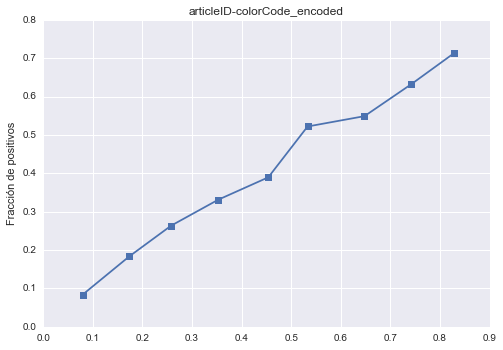

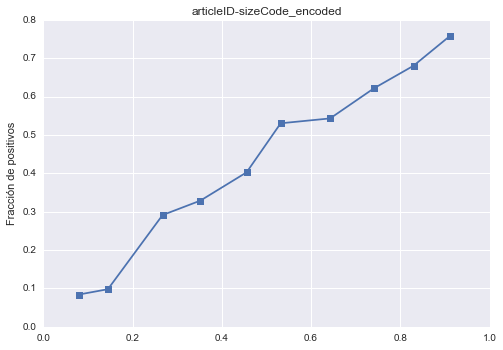

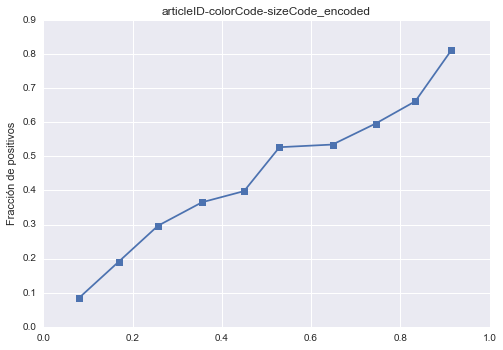

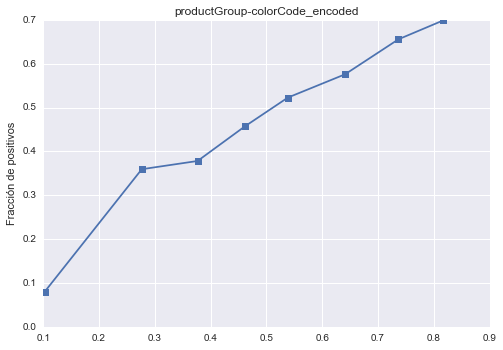

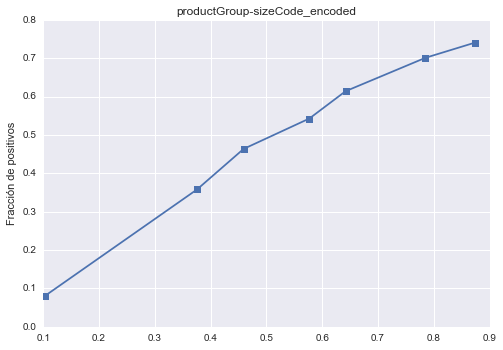

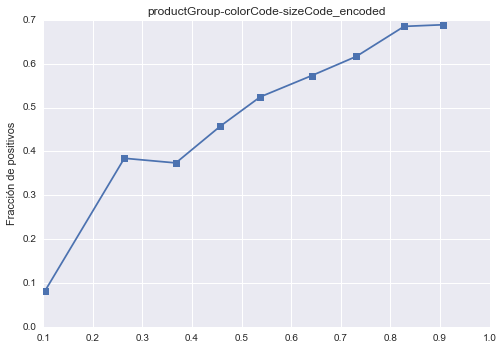

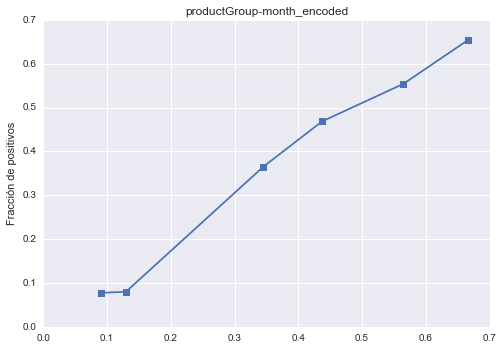

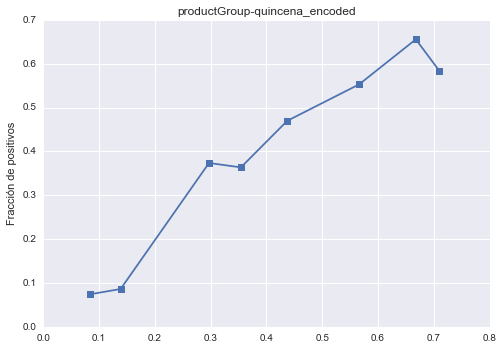

In [36]:
test = pd.read_pickle(mway_path + "fold_3.p")
encoded_cols = test.filter(regex="_encoded$").columns

for c in encoded_cols:
    ax = plt.figure().add_subplot(111)
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test > 0, test[c], n_bins=10)
    ax.plot(mean_predicted_value, fraction_of_positives, "s-")
    ax.set_ylabel("Fracción de positivos")
    ax.set_title(c)

In [38]:
if False:
#for i, fold in enumerate(folds):
    if i != 2: continue

    if os.path.exists(target_path + "fold_" + str(i + 1) + ".p"):
        continue

    if i < 3:
        train = pd.read_csv(data_path + "train.txt", sep=";", na_values="NA",
                            keep_default_na=False, parse_dates=[1])
        valid = train[(train.orderDate >= fold[1][0]) & (train.orderDate <= fold[1][1])]
        train = train[train.orderDate <= fold[0]]
    else:
        train = pd.read_csv(data_path + "train.txt", sep=";", na_values="NA",
                            keep_default_na=False, parse_dates=[1])
        valid = pd.read_csv(data_path + "test.txt", sep=";", na_values="NA",
                            keep_default_na=False, parse_dates=[1])

    train_q = train[["customerID", "articleID", "quantity", "returnQuantity"]].copy()
    train_q.set_index("customerID", inplace=True)
    orders = valid.orderID.unique().shape[0]

    valid_res = valid[index_cols].copy()
    valid_res["ret_ratio"] = 0
    valid_res["jac_ret"] = 0
    valid_res["jac_noret"] = 0
    valid_res["rebuy"] = 0
    valid_res["returned"] = 0
    valid_res.set_index(["orderID", "articleID"], inplace=True)

    baskets = train.groupby("customerID").articleID.apply(np.unique).map(set)
    valid_baskets = valid.groupby("customerID").articleID.apply(np.unique).map(set)
    p_order = 0
    start = datetime.datetime.now()
    for orderID, case in valid.groupby("orderID"):
        p_order += 1
        customerID = case.customerID.unique()[0]
        custumer_baskets = valid_baskets.ix[customerID]
        if customerID in baskets.index:
            custumer_baskets = custumer_baskets.union(baskets.ix[customerID])
        for articleID in case.articleID.unique():
            candidates = baskets.ix[train[train.articleID == articleID].customerID.unique()]
            if len(candidates) == 0: continue
            returned = train_q.ix[candidates.index]
            returned = returned[returned.articleID == articleID]
            returned = returned.reset_index().groupby("customerID").sum()
            returned = (returned.returnQuantity / returned.quantity).fillna(0)
            returned.name = "returned"

            jac_dist = candidates.map(lambda x: len(custumer_baskets.intersection(x)) / len(custumer_baskets.union(x)))
            jac_dist.name = "jac_dist"

            valid_res.ix[(orderID, articleID), "ret_ratio"] = pd.concat([jac_dist, returned], axis=1).prod(axis=1).mean()
            temp = pd.concat([jac_dist, returned>=0.5], axis=1).groupby("returned").mean()
            if True in temp.index:
                valid_res.ix[(orderID, articleID), "jac_ret"] = temp.ix[True].values[0]
            if False in temp.index:
                valid_res.ix[(orderID, articleID), "jac_noret"] = temp.ix[False].values[0]

            if customerID in candidates.index:
                valid_res.ix[(orderID, articleID), "rebuy"] = True
                returned = train_q.ix[[customerID]]
                returned = returned[returned.articleID == articleID]
                if returned.quantity.sum() > 0:
                    returned = returned.returnQuantity.sum() / returned.quantity.sum()
                else:
                    returned = min(1, returned.returnQuantity.sum())
                valid_res.ix[(orderID, articleID), "returned"] = returned
        if p_order % 100 == 0:
            enlapsed = (datetime.datetime.now() - start).seconds / 60.0
            pct = round(p_order / orders * 100, 2)
            rm = round((enlapsed / p_order * orders - enlapsed) / 60, 2)
            print("hecho {0}% del fold {1}, tiempo restante: {2} horas".format(pct, i + 1, rm))

    valid_res["jac_ratio"] = valid_res.jac_ret / (valid_res.jac_noret + 1e-35)

    valid_res.reset_index().to_pickle(target_path + "fold_" + str(i + 1) + ".p")

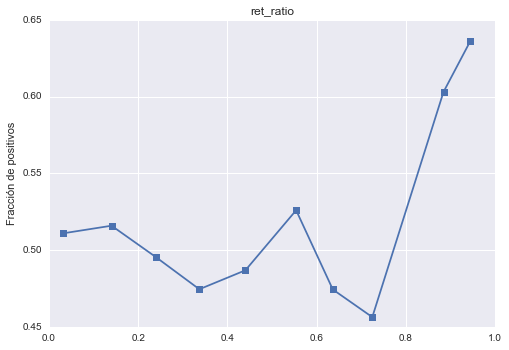

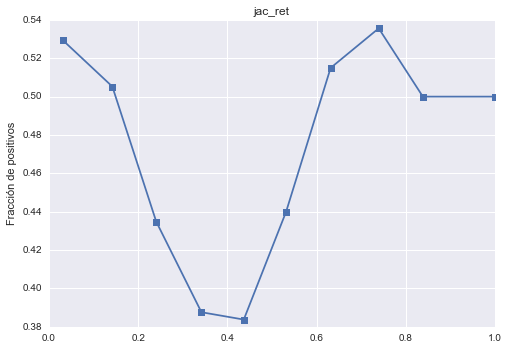

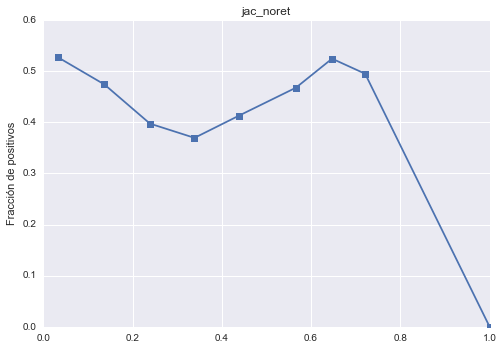

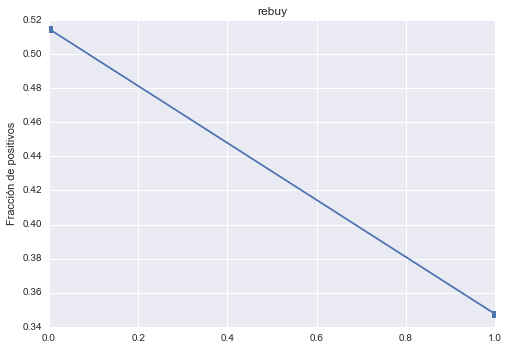

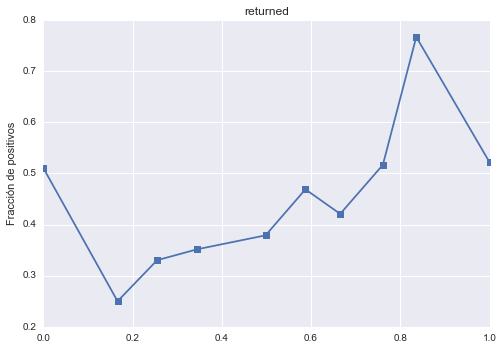

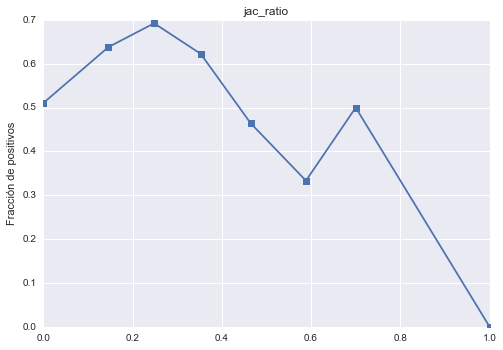

In [42]:
test = pd.read_pickle(reco_path + "fold_3.p")
encoded_cols = ["ret_ratio", "jac_ret", "jac_noret", "rebuy", "returned", "jac_ratio"]

for c in encoded_cols:
    ax = plt.figure().add_subplot(111)
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test > 0, 
                                                                    test[c].astype(np.float), n_bins=10, normalize=True)
    ax.plot(mean_predicted_value, fraction_of_positives, "s-")
    ax.set_ylabel("Fracción de positivos")
    ax.set_title(c)

### Entrenamiento de los algoritmos

<img src="files/flow.png">

### Selección de Modelos

Una vez que hay una cantidad importante de modelos entrenados sobre un único fold, se procede a correr una regresión logística con penalidad l1, la penalidad l1 (que agrega un término con el valor obsoluto de los coeficientes a la función de pérdida), tiende a encontrar una solución "escase" (sparse), posiblemente el término en español más próximo sería "parsimoniosa", es decir, tiende a hacer 0 los coeficientes de las variables menos importantes. Es un método que usualmente su usa para selección de variables pero, como en nuestro caso las variables son los resultados de muchos modelos, nos sirve para saber qué modelos entrenar en todos los folds. 

### Entrenamiento de los modelos finales de stage 1 y entrenamiento del modelo final

Luego se entrenan los modelos seleccionados en el paso anterior contra todos los folds. Con esos resultados, más las "meta features" (multi way y recomendador) se entrena un modelo final



In [72]:
test = pd.read_pickle(stage_1_path + "fold_3.p").drop(["orderID", "articleID", "colorCode", "sizeCode"], axis=1)
test_2 = pd.read_pickle(stage_2_path + "fold_3.p").drop(["orderID", "articleID", "colorCode", "sizeCode"], axis=1)

In [70]:
resultado = pd.Series(np.zeros((test.shape[1] + 1,)), index=test.columns.tolist() + ["FINAL"])
for clf in test.columns:
    resultado.ix[clf] = np.abs(y_test.values - (test[clf].values >= 0.5).astype(int)).sum()
resultado.ix["FINAL"] = np.abs(y_test.values - (test_2["XGBClassifier"].values >= 0.5).astype(int)).sum()

In [76]:
res = pd.concat([resultado.sort_values(), resultado.sort_values()/test.shape[0]], axis=1)
res.columns = ["Valor Absoluto", "Valor Relativo"]
res

,Valor Absoluto,Valor Relativo
FINAL,119406.0,0.323430
XGBClassifier_208,120884.0,0.327433
XGBClassifier_656,120956.0,0.327628
XGBClassifier_590,121020.0,0.327801
XGBClassifier_419,121032.0,0.327834
XGBClassifier_20,121077.0,0.327956
XGBClassifier_333,121120.0,0.328072
XGBClassifier_687,121126.0,0.328088
XGBClassifier_761,121148.0,0.328148
XGBClassifier_746,121167.0,0.328200
